In [1]:
import numpy as np
import pandas as pd

In [2]:
import csv

In [3]:
df = pd.read_csv('HW2housing.csv', delimiter=',')
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [4]:
# Drop ocean_proximity column
df_work = df.drop(df.columns[[-1]], axis = 1)

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Data has a long tail


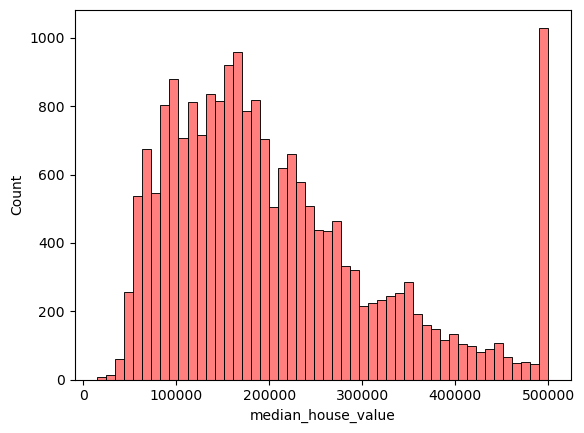

In [6]:
sns.histplot(df.median_house_value, bins = 50, alpha = 0.5, color = 'red')
print('Data has a long tail')

#### Q1 Find a feature with missing values. How many missing values does it have?

In [7]:
df_work.isnull().sum().max()

207

#### Q2 What's the median (50% percentile) for the variable 'population'?

In [8]:
df_work.population.median()

1166.0

#### Data spliting

In [9]:
n = len(df_work)
n_train = int(n*0.6)
n_val = int(n*0.2)
n_test = n - n_train - n_val
n_train, n_val, n_test, n == n_train + n_val + n_test

(12384, 4128, 4128, True)

In [10]:
np.random.seed(42)
index = np.arange(n)
np.random.shuffle(index)
index

array([20046,  3024, 15663, ...,  5390,   860, 15795])

In [11]:
df_train = df_work.iloc[index[:n_train]]
df_val = df_work.iloc[index[n_train:n_train + n_val]]
df_test = df_work.iloc[index[n_train+ n_val:]]

In [12]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [13]:
y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

In [14]:
df_train = df_train.drop(df_train.columns[[-1]], axis = 1)
df_val = df_val.drop(df_val.columns[[-1]], axis = 1)
df_test = df_test.drop(df_test.columns[[-1]], axis = 1)

In [15]:
df_train.shape, df_val.shape, df_test.shape

((12384, 8), (4128, 8), (4128, 8))

#### Q3  Dealing with missing values

In [16]:
def train_linear_regression(X,y):
    ones = np.ones(X.shape[0])
    X = (np.column_stack([ones,X]))
    
    XTX = np.transpose(X).dot(X)
    XTX_inv = np.linalg.inv(XTX)
    
    w_full = XTX_inv.dot(X.T).dot(y)
    w0 = w_full[0]
    w = w_full[1:]
    
    return w0, w

In [17]:
def rmse(y,y_pred):
    error = y - y_pred
    se = error ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [18]:
# 1 - filling NANs with 0
X_train_0 = df_train.fillna(0).values
X_val_0 = df_val.fillna(0).values

In [32]:
w0_0, w_0 = train_linear_regression(X_train_0, y_train)
y_pred_0 = w0_0 + X_val_0.dot(w_0)
round(rmse(y_val, y_pred_0), 2)

0.33

In [33]:
round(rmse(y_val, y_pred_0), 2)

0.33

In [34]:
# 2 - filling NANs with mean
mean_X_train = df_train.total_bedrooms.mean()
X_train_mean = df_train.fillna(mean_X_train).values
X_val_mean = df_val.fillna(mean_X_train).values

In [35]:
w0_mean, w_mean = train_linear_regression(X_train_mean, y_train)
y_pred_mean = w0_mean + X_val_mean.dot(w_mean)
round(rmse(y_val, y_pred_mean), 2)

0.33

#### Q4 regularized linear regression

In [36]:
def train_linear_regression_reg(X,y,r):
    ones = np.ones(X.shape[0])
    X = (np.column_stack([ones,X]))
    
    XTX = np.transpose(X).dot(X)
    XTX = XTX + r*np.eye(XTX.shape[0])
    XTX_inv = np.linalg.inv(XTX)
    
    w_full = XTX_inv.dot(X.T).dot(y)
    w0 = w_full[0]
    w = w_full[1:]
    
    return w0, w

In [37]:
r = [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]

In [38]:
df_val.shape

(4128, 8)

In [41]:
reg_result = {}
for i in r:
    X_val_0 = df_val.fillna(0).values
    
    w0, w = train_linear_regression_reg(X_train_0, y_train,i)
    y_pred_val = w0 + X_val_0.dot(w)
    
    error = y_val - y_pred_val
    se = error ** 2
    mse = se.mean()
    reg_result[i] = round(np.sqrt(mse),2)
reg_result

{0: 0.33,
 1e-06: 0.33,
 0.0001: 0.33,
 0.001: 0.33,
 0.01: 0.33,
 0.1: 0.33,
 1: 0.33,
 5: 0.34,
 10: 0.34}

Q4 answer: RMSE is equel for r = [0, 0.000001, 0.0001, 0.001, 0.01, 0.1] Wich means the answer is smallest r,  
r = 0

#### Q5 Using different seeds

In [60]:
def split(seed, df):
    n, n_train, n_val, n_test = [20640, 12384, 4128, 4128]
    np.random.seed(seed)
    index = np.arange(n)
    np.random.shuffle(index)

    df_train = df_work.iloc[index[:n_train]]
    df_val = df_work.iloc[index[n_train:n_train + n_val]]
    df_test = df_work.iloc[index[n_train+ n_val:]]

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    y_train = np.log1p(df_train.median_house_value.values)
    y_val = np.log1p(df_val.median_house_value.values)
    y_test = np.log1p(df_test.median_house_value.values)

    df_train = df_train.drop(df_train.columns[[-1]], axis = 1)
    df_val = df_val.drop(df_val.columns[[-1]], axis = 1)
    df_test = df_test.drop(df_test.columns[[-1]], axis = 1)
    
    answer = [df_train, df_val, df_test, y_train, y_val, y_test]
    return answer

In [61]:
list_res = []
seed = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
for i in seed:
    df_train_s = split(i,df_work)[0]
    df_val_s = split(i,df_work)[1]
    y_train_s = split(i,df_work)[3]
    y_val_s = split(i,df_work)[4]
    
    X_train_s = df_train_s.fillna(0).values
    w0_s, w_s = train_linear_regression(X_train_s, y_train_s)
    
    X_val_s = df_val_s.fillna(0).values
    y_pred_val = w0_s + X_val_s.dot(w_s)
    rmse_val = rmse(y_val_s, y_pred_val)
    
    list_res.append(rmse_val)

    list_res

In [62]:
round(np.std(np.array(list_res)), 3)
f"Q5 answer - standard deviation of all the RMSE scores = {round(np.std(np.array(list_res)), 3)}"

'Q5 answer - standard deviation of all the RMSE scores = 0.004'

#### Q6 Full training

In [63]:
df_train_s9 = split(9,df_work)[0]
df_val_s9 = split(9,df_work)[1]
df_test_s9 = split(9,df_work)[2]
y_train_s9 = split(9,df_work)[3]
y_val_s9 = split(9,df_work)[4]
y_test_s9 = split(9,df_work)[5]

In [64]:
y_full_train_s9 = np.concatenate([y_train_s9, y_val_s9])

In [65]:
X_full_train_s9 = pd.concat([df_train_s9, df_val_s9])
X_full_train_s9 = X_full_train_s9.fillna(0).values

In [66]:
w0_full_s9, w_full_s9 = train_linear_regression_reg(X_full_train_s9, y_full_train_s9, 0.001)
y_pred_full9 = w0_full_s9 + X_full_train_s9.dot( w_full_s9)

In [67]:
X_test_s9 = df_test_s9.fillna(0).values
X_test_s9.shape, y_test_s9.shape

((4128, 8), (4128,))

In [68]:
y_pred_test9 = w0_full_s9 + X_test_s9.dot(w_full_s9)

In [70]:
rmse9 = rmse(y_test_s9, y_pred_test9)
f"Q6 answer - RMSE = {round(rmse9,2)}"

'Q6 answer - RMSE = 0.35'

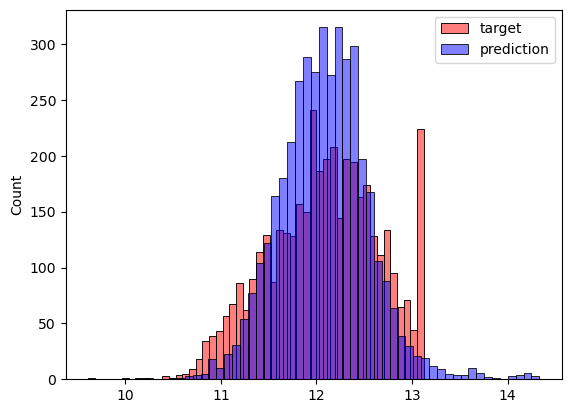

In [73]:
sns.histplot(y_test_s9, label='target', color='red', alpha=0.5, bins=50)
sns.histplot(y_pred_test9, label='prediction', color='blue',  alpha=0.5, bins=50)
plt.legend()